# 02. Neural Network classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things at the options).

## 1. Make classification data and get it ready

In [1]:
import sklearn

In [ ]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

: 

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
X[:5], y[:5]    

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0], dtype=int64))

In [5]:
# Makde DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


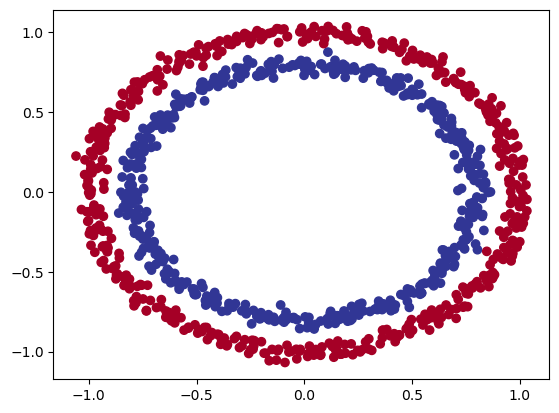

In [6]:
# Visualize the data!
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

**Note:** The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals.

### 1.1 Check input and output shapes

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [ ]:
import torch
torch.__version__

: 

In [10]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [11]:
type(X), X.dtype

(torch.Tensor, torch.float32)

In [12]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

In [13]:
len(X_train), len(X_test)

(800, 200)

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code so our code will run on any device
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [14]:
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Now we've setup device agnostic code, let's create a model:

1. Subclass `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear` layers which will serve as our input and output layers.
3. Define a forward method which will take in some input tensor and pass it through the layers we've defined.
4. Instantiate an instance of our model and send it to the target device.

In [15]:
# 1. Construct a model that subclasses nn.Module

class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()

        # 2. Create 2 nn.Linear layers
        self.linear1 = nn.Linear(in_features=2, out_features=128)
        self.linear2 = nn.Linear(in_features=128, out_features=1)

        # 3. Define the forward method
        def forward(self, X):
            out = self.linear1(X)
            out = self.linear2(out)
            return out

In [16]:
model_0 = CircleModelV1().to(device)
model_0

CircleModelV1(
  (linear1): Linear(in_features=2, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=1, bias=True)
)

In [17]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [18]:
# Let's replicate the model above using nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=128),
    nn.Linear(in_features=128, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=128, bias=True)
  (1): Linear(in_features=128, out_features=1, bias=True)
)

In [19]:
# it can also be done like this
class CircleModelV1alt(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(in_features=2, out_features=128),
            nn.Linear(in_features=128, out_features=1)
        )

    def forward(self, X):
        return self.model(X)

In [20]:
# Make predictions
model_0.eval()
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
    
print(f"Length of predictions: {len(untrained_preds)}, shape: {untrained_preds.shape}")
print(f"Predictions: {untrained_preds[:5]}")

Length of predictions: 200, shape: torch.Size([200, 1])
Predictions: tensor([[-0.5786],
        [-0.5329],
        [-0.4789],
        [-0.6078],
        [-0.1302]], device='cuda:0')


### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?

For classification, we might want to use binary cross entropy (`nn.BCELoss`) or categorical cross entropy (`nn.CrossEntropyLoss`), and for the optimizer, we might want to use SGD (stochastic gradient descent) or something like Adam.

* For the loss function, we're going to use `torch.nn.BECWithLogitsLoss` which combines a sigmoid activation function and and binary cross entropy loss in one class. This way we don't need to add a sigmoid activation function to our model, the sigmoid activation function is be included in the loss function.

In [21]:
# Setup the loss function
# loss_fn = nn.BCELoss() - requires inputs to have gone through a sigmoid function prior to using the loss
loss_fn = nn.BCEWithLogitsLoss() # sigmoid function is included

# Setup the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

In [22]:
# Calculate accuracy function
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_true)) * 100
    return acc

## 3. Train model

To train our model, we're going to need to build a training loop:
1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backwards (backpropagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits** (the predictions before passing through an activation function, such as a sigmoid or softmax).

We can convert these **logits** into prediction probabilites by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`.

In [23]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.5786],
        [-0.5329],
        [-0.4789],
        [-0.6078],
        [-0.1302]], device='cuda:0')

In [24]:
# Use the sigmoid function to turn logits into probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.3593],
        [0.3699],
        [0.3825],
        [0.3526],
        [0.4675]], device='cuda:0')

For our prediction probability values, we need to perform a range-style rounding them:
* `0.5` or greater -> 1
* less than `0.5` -> 0

(but we can also change the threshold)

In [25]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> prediction probs -> prediction labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))))
y_pred_labels[:10]

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0', grad_fn=<SliceBackward0>)

### 3.2 Building and training a test loop

In [26]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(1, epochs+1):
    ### TRAINING
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probs -> pred labels

    # 2. Calculate loss/accuracy
    # Note: the loss function has an in-built sigmoid function, so we have to pass it the logits
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Backward pass
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### TESTING
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

    # Print the results
    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{epochs}]. | Loss: {loss:.4f}. | Acc: {acc:.2f}. | Test loss: {test_loss:.4f}. | Test acc: {test_acc:.2f}")


Epoch [10/100]. | Loss: 0.7035. | Acc: 41.50. | Test loss: 0.7021. | Test acc: 43.50
Epoch [20/100]. | Loss: 0.6981. | Acc: 46.25. | Test loss: 0.6977. | Test acc: 45.50
Epoch [30/100]. | Loss: 0.6957. | Acc: 48.12. | Test loss: 0.6959. | Test acc: 45.00
Epoch [40/100]. | Loss: 0.6945. | Acc: 49.38. | Test loss: 0.6951. | Test acc: 44.00
Epoch [50/100]. | Loss: 0.6939. | Acc: 49.75. | Test loss: 0.6948. | Test acc: 46.00
Epoch [60/100]. | Loss: 0.6935. | Acc: 48.62. | Test loss: 0.6947. | Test acc: 50.00
Epoch [70/100]. | Loss: 0.6933. | Acc: 48.62. | Test loss: 0.6946. | Test acc: 50.00
Epoch [80/100]. | Loss: 0.6932. | Acc: 49.12. | Test loss: 0.6946. | Test acc: 49.50
Epoch [90/100]. | Loss: 0.6931. | Acc: 50.00. | Test loss: 0.6946. | Test acc: 49.00
Epoch [100/100]. | Loss: 0.6930. | Acc: 50.12. | Test loss: 0.6946. | Test acc: 48.50


## 4. Make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything

Let's visualize the model's predictions to figure out why.

To do so, we're going to import a function called `plot_decision_boundary` from `helper_functions.py` which will allow us to see how our model is making predictions.
https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [27]:
import requests
from pathlib import Path

# Download helper functions from GitHub (if it's not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists. Skipping download.")
else:
    url = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"
    get_url = requests.get(url)
    with open("helper_functions.py", "w") as f:
        f.write(get_url.text)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists. Skipping download.


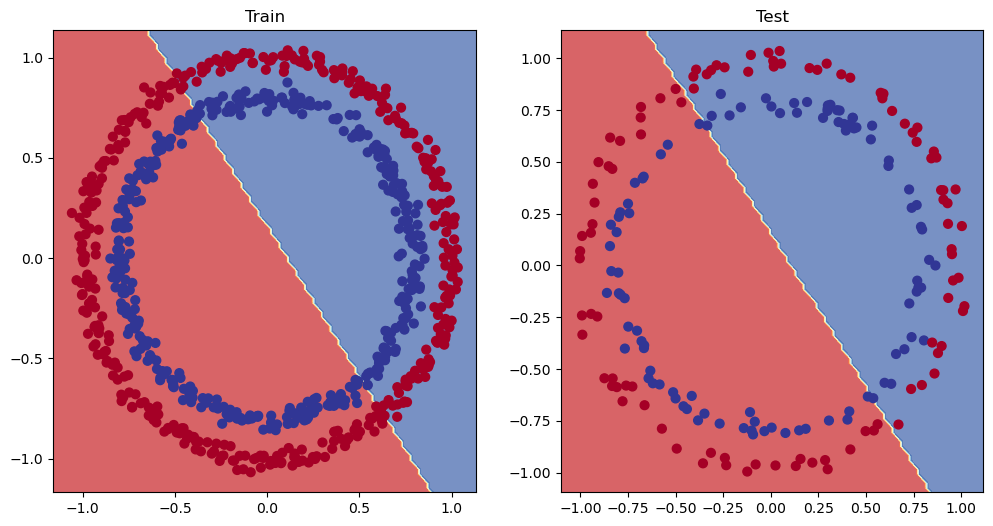

In [28]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units
* Train for longer
* Change the activation functions
* Change the learning rate
* Change the loss function

These options are all from a model's perspective because they deal directly with the model, rather than the data.

And because these option are all values we can change, they are often referred to as **hyperparameters**.

Let's try and improve our model by:
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000

In [29]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=64)
        self.layer_2 = nn.Linear(in_features=64, out_features=64)
        self.layer_3 = nn.Linear(in_features=64, out_features=1)

    def forward(self, X):
        return self.layer_3(self.layer_2(self.layer_1(X)))
    
model_1 = CircleModelV2().to(device)

In [30]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)

In [31]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(1, epochs+1):
    ### TRAINING
    model_1.train()

    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probs -> pred labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Backward pass
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### TESTING
    model_1.eval()
    with  torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)
    
    # Print the results
    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{epochs}]. | Loss: {loss:.4f}. | Acc: {acc:.2f}. | Test loss: {test_loss:.4f}. | Test acc: {test_acc:.2f}")

Epoch [100/1000]. | Loss: 0.6944. | Acc: 51.25. | Test loss: 0.7010. | Test acc: 46.00
Epoch [200/1000]. | Loss: 0.6934. | Acc: 51.12. | Test loss: 0.6976. | Test acc: 46.50
Epoch [300/1000]. | Loss: 0.6931. | Acc: 51.00. | Test loss: 0.6961. | Test acc: 46.50
Epoch [400/1000]. | Loss: 0.6930. | Acc: 51.12. | Test loss: 0.6954. | Test acc: 46.00
Epoch [500/1000]. | Loss: 0.6930. | Acc: 51.38. | Test loss: 0.6951. | Test acc: 46.00
Epoch [600/1000]. | Loss: 0.6930. | Acc: 51.38. | Test loss: 0.6949. | Test acc: 45.50
Epoch [700/1000]. | Loss: 0.6930. | Acc: 51.50. | Test loss: 0.6948. | Test acc: 45.00
Epoch [800/1000]. | Loss: 0.6930. | Acc: 51.38. | Test loss: 0.6947. | Test acc: 45.00
Epoch [900/1000]. | Loss: 0.6930. | Acc: 51.25. | Test loss: 0.6947. | Test acc: 45.50
Epoch [1000/1000]. | Loss: 0.6930. | Acc: 51.12. | Test loss: 0.6947. | Test acc: 45.50


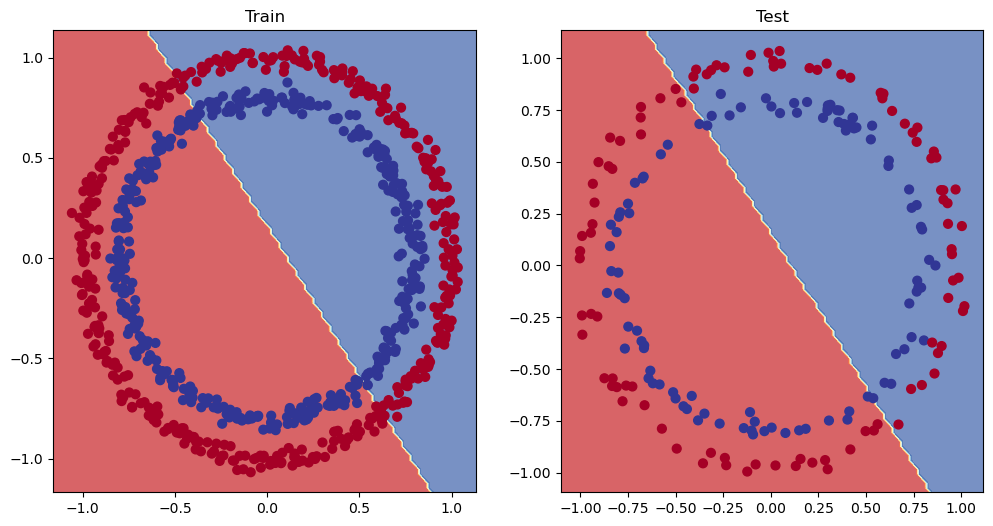

In [32]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot a larger problem is to start with a simpler problem.

In [33]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

# Check the data
print(len(X_regression), len(y_regression))
print(X_regression[:5], y_regression[:5])

100 100
tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400]]) tensor([[0.3000],
        [0.3070],
        [0.3140],
        [0.3210],
        [0.3280]])


In [34]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, X_test_regression = X_regression[:train_split], X_regression[train_split:]
y_train_regression, y_test_regression = y_regression[:train_split], y_regression[train_split:]

# Check the splits
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

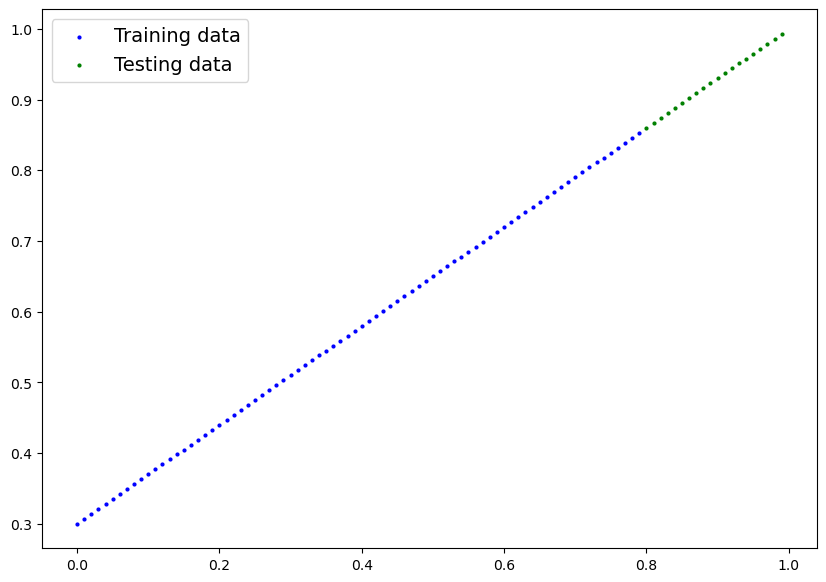

In [35]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

### 5.2 Adjusting `model_1` to fit a straight line

In [36]:
# Same architecture as model_1 but using nn.Sequential()
model_2 = nn.Sequential(
    nn.Linear(1, 64),
    nn.Linear(64, 64),
    nn.Linear(64, 1)
).to(device)

next(model_2.parameters()).device

device(type='cuda', index=0)

In [37]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

In [38]:
# Training and evaluation loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, X_test_regression, y_train_regression, y_test_regression = X_train_regression.to(device), X_test_regression.to(device), y_train_regression.to(device), y_test_regression.to(device)

# Build training and evaluation loop
for epoch in range(1, epochs+1):
    ### TRAINING
    model_2.train()

    # 1. Forward pass
    y_pred = model_2(X_train_regression)

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_pred, y_train_regression)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Backward pass
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### TESTING
    model_2.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_pred = model_2(X_test_regression)

        # 2. Calculate loss/accuracy
        test_loss = loss_fn(test_pred, y_test_regression)
    
    # Print the results
    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{epochs}]. | Loss: {loss:.4f}. | Test loss: {test_loss:.4f}")

Epoch [100/1000]. | Loss: 0.1089. | Test loss: 0.0056
Epoch [200/1000]. | Loss: 0.0859. | Test loss: 0.0170
Epoch [300/1000]. | Loss: 0.0597. | Test loss: 0.0135
Epoch [400/1000]. | Loss: 0.0524. | Test loss: 0.0095
Epoch [500/1000]. | Loss: 0.0508. | Test loss: 0.0122
Epoch [600/1000]. | Loss: 0.0401. | Test loss: 0.0039
Epoch [700/1000]. | Loss: 0.0391. | Test loss: 0.0043
Epoch [800/1000]. | Loss: 0.0411. | Test loss: 0.0080
Epoch [900/1000]. | Loss: 0.0400. | Test loss: 0.0052
Epoch [1000/1000]. | Loss: 0.0401. | Test loss: 0.0033


<Figure size 1200x600 with 0 Axes>

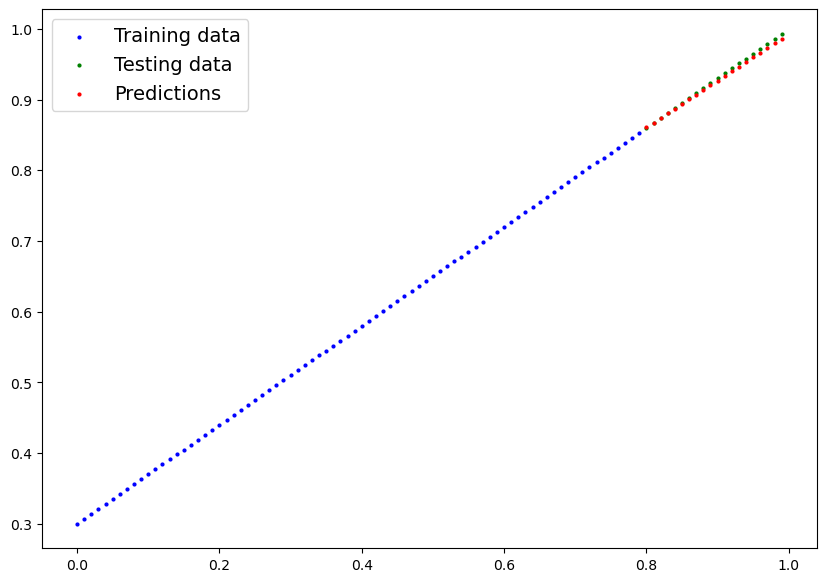

In [39]:
# Predictions
model_2.eval()
with torch.inference_mode():
    y_preds = model_2(X_test_regression)
    y_preds = y_preds.detach().cpu().numpy()

# Plot the predictions
plt.figure(figsize=(12,6))
plot_predictions(train_data=X_train_regression.cpu(),
                train_labels=y_train_regression.cpu(),
                test_data=X_test_regression.cpu(),
                test_labels=y_test_regression.cpu(),
                predictions=y_preds)

## 6. The missing piece: non-linearity

The reason the model can't separate two different circles is because it's trying to fit a straight line.

### 6.1 Recreating non-linear data (red and blue circles)

For the sake of practice

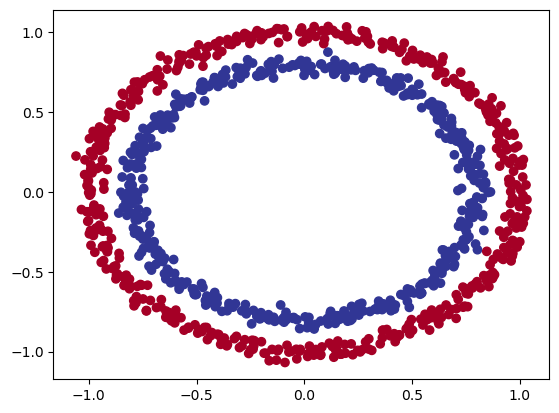

In [40]:
n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0],
            X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [41]:
# Convert data to tensors and then to train and test splits

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

In [42]:
len(X_train), len(X_test), X_train[:5], y_train[:5]

(800,
 200,
 tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

To add non-linearity to our model, we can add an activation function to our hidden layers.

In [43]:
# Build a model with non-linear activtaion functions
class CircleModelV3(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(in_features=2, out_features=64)
        self.layer_2 = nn.Linear(in_features=64, out_features=64)
        self.layer_3 = nn.Linear(in_features=64, out_features=1)
        self.relu = nn.ReLU() # relu is a non-linear activation function

    def forward(self, x):
        # Where should we put the freaking relu function?

        # Answer: after each linear layer
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV3().to(device)

In [44]:
model_3, next(model_3.parameters()).device

(CircleModelV3(
   (layer_1): Linear(in_features=2, out_features=64, bias=True)
   (layer_2): Linear(in_features=64, out_features=64, bias=True)
   (layer_3): Linear(in_features=64, out_features=1, bias=True)
   (relu): ReLU()
 ),
 device(type='cuda', index=0))

In [45]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.01)

In [46]:
# Training and evaluation loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 10000

# Put data to target device
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(1, epochs+1):
    ### TRAINING
    model_3.train()

    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_preds)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Backward pass
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### TESTING
    model_3.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_3(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_preds)
    
    # Print the results
    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{epochs}]. | Loss: {loss:.4f}. | Acc: {acc:.2f}. | Test loss: {test_loss:.4f}. | Test acc: {test_acc:.2f}")


Epoch [100/10000]. | Loss: 0.6901. | Acc: 52.00. | Test loss: 0.6929. | Test acc: 53.00
Epoch [200/10000]. | Loss: 0.6890. | Acc: 53.00. | Test loss: 0.6921. | Test acc: 51.00
Epoch [300/10000]. | Loss: 0.6879. | Acc: 55.25. | Test loss: 0.6912. | Test acc: 52.00
Epoch [400/10000]. | Loss: 0.6868. | Acc: 55.50. | Test loss: 0.6904. | Test acc: 53.00
Epoch [500/10000]. | Loss: 0.6857. | Acc: 57.00. | Test loss: 0.6896. | Test acc: 54.50
Epoch [600/10000]. | Loss: 0.6846. | Acc: 58.13. | Test loss: 0.6887. | Test acc: 53.50
Epoch [700/10000]. | Loss: 0.6834. | Acc: 59.75. | Test loss: 0.6878. | Test acc: 54.00
Epoch [800/10000]. | Loss: 0.6822. | Acc: 61.38. | Test loss: 0.6870. | Test acc: 54.50
Epoch [900/10000]. | Loss: 0.6810. | Acc: 62.12. | Test loss: 0.6860. | Test acc: 54.50
Epoch [1000/10000]. | Loss: 0.6797. | Acc: 63.75. | Test loss: 0.6851. | Test acc: 56.00
Epoch [1100/10000]. | Loss: 0.6783. | Acc: 65.25. | Test loss: 0.6840. | Test acc: 57.50
Epoch [1200/10000]. | Loss: 0.

### 6.4 Evaluating a model trained with non-linear activation functions

In [47]:
# Make predictions
model_3.to(device)
model_3.eval()
with torch.inference_mode():
    y_preds = model_3(X_test).squeeze()
    y_preds = torch.round(torch.sigmoid(y_preds))
y_preds[:10], y_test[:10], accuracy_fn(y_test, y_preds)

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 100.0)

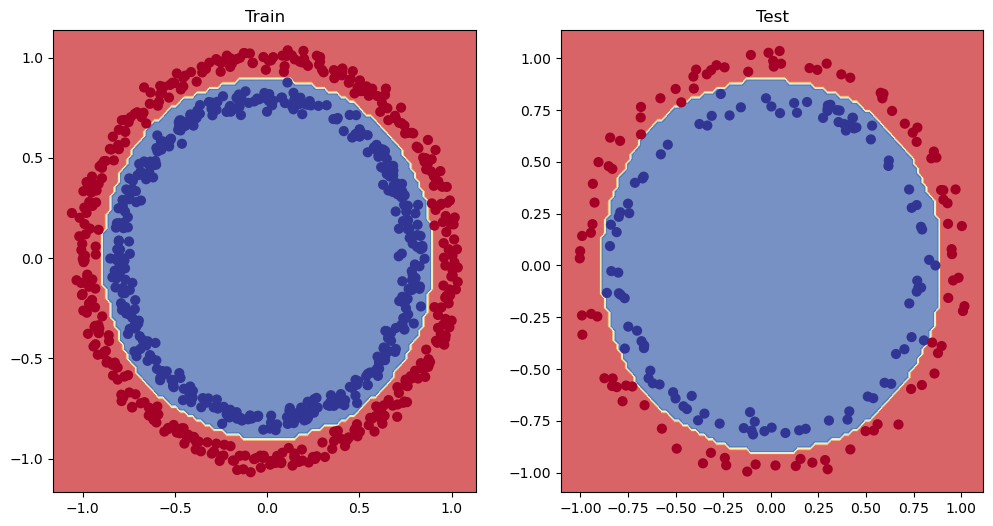

In [48]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## 7. Replicating non-linear activation functions

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own.

And these tools are linear & non-linear functions.

In [49]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

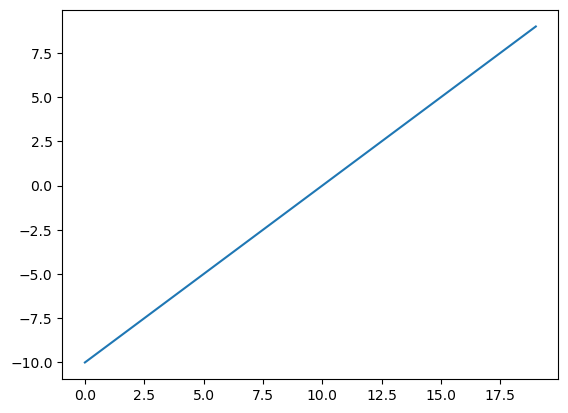

In [50]:
# Visualize the tensor
plt.plot(A)

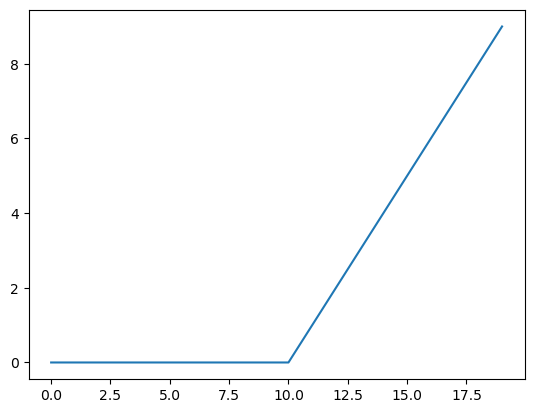

In [51]:
plt.plot(torch.relu(A))

In [52]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.max(torch.tensor(0), x)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])


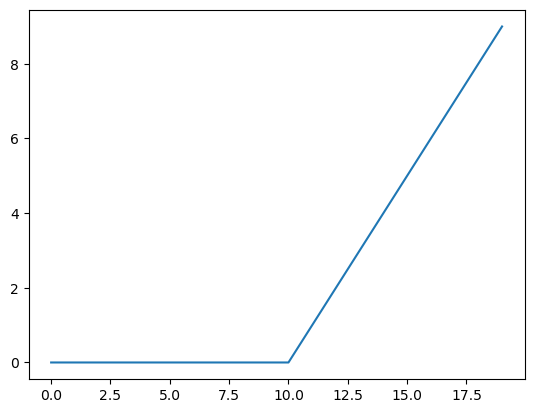

In [53]:
print(relu(A))
plt.plot(relu(A))

In [54]:
# Sigmoid time
def sigmoid(x: torch.Tensor) -> torch.Tensor:
    return 1 / (1+ torch.exp(-x))

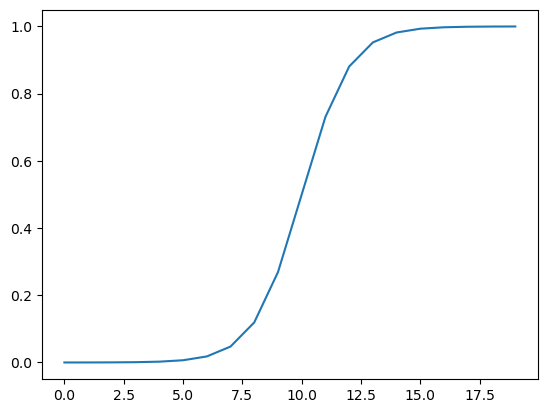

In [55]:
plt.plot(torch.sigmoid(A))

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])


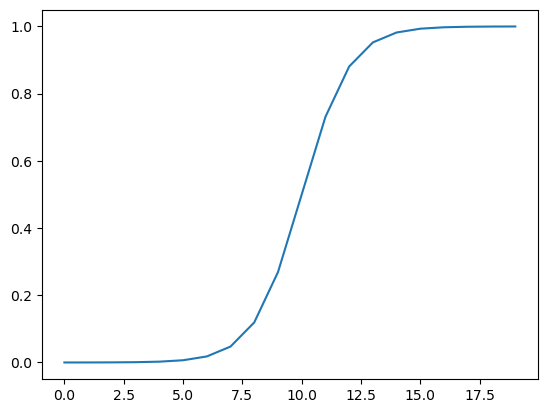

In [56]:
print(sigmoid(A))
plt.plot(sigmoid(A))

## 8. Putting it all together with a multi-class classification problem


### 8.1 Creating a toy multi-class dataset

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters or data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            centers=NUM_CLASSES,
                            n_features=NUM_FEATURES,
                            cluster_std=1.5, # introduce some standard deviation between the blobs
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train,  y_blob_test = train_test_split(X_blob, y_blob,
                                                                         test_size=0.2,
                                                                         random_state=RANDOM_SEED)

# 4. Plot the data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0],
            X_blob[:, 1],
            c=y_blob,
            cmap=plt.cm.RdYlBu)


: 

### 8.2 Building a multi-class classification model in PyTorch

In [98]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [99]:
# Build a multi-class classification model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes multi-class classification model.
        
        Args:
            input_features (int):  Number of input features
            output_features (int): Number of output features (classes)
            hidden_units (int): Number of hidden units between layers, default 8
        
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(input_features, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_features)
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)
    
# Instantiate the model
model_4 = BlobModel(input_features=NUM_FEATURES, output_features=NUM_CLASSES).to(device)

### 8.3 Create a loss function and an optimizer for the multi-class classification model

In [100]:
# Create a loss funciton
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.01)

### 8.4 Getting prediction probabilities for a multi-class PyTorch model

In order to evaluate and train and test our model, we need to convert our model's outputs (logits) to prediction probabilities and then to prediction labels.

Logits (raw output) -> probabilities (use `torch.softmax`) -> labels (take the `argmax` of the probabilities)

In [101]:
model_4.eval()
with torch.inference_mode():
    y_preds = model_4(X_blob_test.to(device))
    print(y_preds[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')


In [102]:
# Convert our model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_preds, dim=1)
print(y_preds[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')


In [103]:
# Convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

### 8.5 Creating a training loop and testing loop for a multi-class PyTorch model

In [104]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to the target device
X_blob_train, X_blob_test, y_blob_train, y_blob_test = X_blob_train.to(device), X_blob_test.to(device), y_blob_train.to(device), y_blob_test.to(device)

# Build training and evaluation loop
for epoch in range(1, epochs+1):
    ### TRAINING
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train).squeeze()
    y_pred_probs = torch.softmax(y_logits, dim=1)
    y_preds = torch.argmax(y_pred_probs, dim=1)

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_blob_train.long())
    acc = accuracy_fn(y_blob_train, y_preds)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### TESTING
    model_4.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_4(X_blob_test).squeeze()
        test_pred_probs = torch.softmax(test_logits, dim=1)
        test_preds = torch.argmax(test_pred_probs, dim=1)

        # 2. Calculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test.long())
        test_acc = accuracy_fn(y_blob_test, test_preds)

    # Print the results
    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{epochs}]. | Loss: {loss:.4f}. | Acc: {acc:.2f}. | Test loss: {test_loss:.4f}. | Test acc: {test_acc:.2f}")


Epoch [100/10000]. | Loss: 0.6464. | Acc: 96.75. | Test loss: 1.7952. | Test acc: 97.00
Epoch [200/10000]. | Loss: 0.4209. | Acc: 98.50. | Test loss: 2.2792. | Test acc: 100.00
Epoch [300/10000]. | Loss: 0.2392. | Acc: 99.25. | Test loss: 2.7614. | Test acc: 99.50
Epoch [400/10000]. | Loss: 0.1050. | Acc: 99.25. | Test loss: 3.4299. | Test acc: 99.50
Epoch [500/10000]. | Loss: 0.0650. | Acc: 99.25. | Test loss: 4.0235. | Test acc: 99.50
Epoch [600/10000]. | Loss: 0.0504. | Acc: 99.25. | Test loss: 4.4575. | Test acc: 99.50
Epoch [700/10000]. | Loss: 0.0429. | Acc: 99.25. | Test loss: 4.7938. | Test acc: 99.50
Epoch [800/10000]. | Loss: 0.0384. | Acc: 99.25. | Test loss: 5.0685. | Test acc: 99.50
Epoch [900/10000]. | Loss: 0.0353. | Acc: 99.25. | Test loss: 5.3005. | Test acc: 99.50
Epoch [1000/10000]. | Loss: 0.0332. | Acc: 99.25. | Test loss: 5.5002. | Test acc: 99.50
Epoch [1100/10000]. | Loss: 0.0316. | Acc: 99.25. | Test loss: 5.6757. | Test acc: 99.50
Epoch [1200/10000]. | Loss: 0

### 8.6 Making and evaluating predictions

In [105]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test).squeeze()
    y_pred_probs = torch.softmax(y_logits, dim=1)
    y_preds = torch.argmax(y_pred_probs, dim=1)

y_logits[:10], y_pred_probs[:10], X_blob_test[:10], y_blob_test[:10], y_blob_test[:10].long()

(tensor([[ -2.4299,  10.8984, -10.1634, -11.2595],
         [ -2.1959,  -9.4513,  -6.2979,   5.2127],
         [ -5.0177,  -5.4211,   5.3746,  -4.3392],
         [ -3.0617,   8.1195,  -5.4886,  -6.6427],
         [  6.4677,  -2.9240, -12.2784,  -8.4365],
         [ -2.7799, -11.1569,  -7.4583,   6.3737],
         [ -4.3848,  -4.6146,   4.6696,  -3.6060],
         [  5.7687,  -6.7762,  -9.7162,  -4.1394],
         [ -6.4314,  -6.9831,   6.6664,  -5.5678],
         [  6.2783,  -5.5532, -10.3133,  -5.4606]], device='cuda:0'),
 tensor([[1.6278e-06, 1.0000e+00, 7.1278e-10, 2.3820e-10],
         [6.0564e-04, 4.2780e-07, 1.0018e-05, 9.9938e-01],
         [3.0665e-05, 2.0486e-05, 9.9989e-01, 6.0438e-05],
         [1.3935e-05, 9.9998e-01, 1.2305e-06, 3.8805e-07],
         [9.9992e-01, 8.3408e-05, 7.2217e-09, 3.3663e-07],
         [1.0583e-04, 2.4351e-08, 9.8349e-07, 9.9989e-01],
         [1.1681e-04, 9.2833e-05, 9.9954e-01, 2.5453e-04],
         [9.9995e-01, 3.5626e-06, 1.8835e-07, 4.9765e-05],

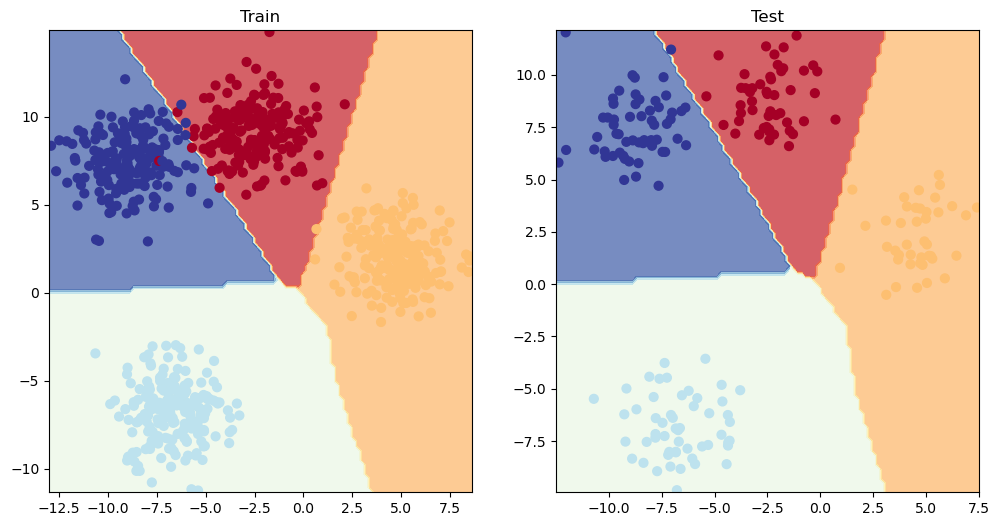

In [106]:
# Plot the decision boundary
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. A few more classification metrics (to evaluate our classification model)

* **Accuracy** - out of all the predictions our model made, how many were correct?
* **Precision** - out of all the positive classes our model predicted, how many were actually positive?
* **Recall** - out of all the positive classes, how many did our model correctly predict?
* **F1 score** - the harmonic mean between precision and recall. A perfect model achieves an F1 score of 1.
* **Confusion matrix** - a table used to describe the performance of a classification model (true positive, false positive, true negative, false negative)
* **Classification report** - a collection of the main classification metrics such as precision, recall and f1 score.

### When to use each?

* **Accuracy** - only when all classes are balanced (e.g. 50% positive, 50% negative)
* **Precision** - when the cost of false positives is high (e.g. email spam detection), you want to minimize the number of false positives
* **Recall** - when the cost of false negatives is high (e.g. disease detection), you want to minimize the number of false negatives
* **F1 score** - when you want to balance false positives and false negatives
* **Confusion matrix** - when you want to understand where your model is getting confused
* **Classification report** - when you want a quick way to see all of the main classification metrics

In [107]:
#TODO: downgrade to python 3.11.5, install pytorch, numpy, pandas, matplotlib, scikit-learn, requests and torchmetrics

ModuleNotFoundError: No module named 'torchmetrics'

In [5]:
%conda install pandas matplotlib scikit-learn requests torchmetrics

error: incomplete escape \U at position 28